# Project: Brazilian medical appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this project I chose the dataset of 100k medical appointments in Brazil, which includes information about the patients and times and locations of the appointments, and whether or not the patient showed up for their appointment. 

The primary question I want to explore is what factors might be important in determining if a patient will show up for their medical appointment?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
df = pd.read_csv('brazil.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape

(110527, 14)

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Can see that there is an error in the Age column because of '-1' value.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


No null values, but many columns need to be changed to other datatypes to be easier to work with.

To datetime: ScheduledDay, AppointmentDay

To bool: Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, No-show

To category: Gender, Handcap, Neighbourhood

In [6]:
df.apply(pd.Series.nunique) #shows the number of unique values in each column

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

Because there are only 27 unique AppointmentDay values it's likely that only the date part is valid and the time part is not. It may be possible to find the days difference between when the appointment was setup and when it takes place to help with analysis. Since there are around twice as many patients than total appointments it could be interesting to look at the patterns of patients with multiple appointments.

In [7]:
df.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

There are more than 2 different values for Handcap, and from reading the information about the dataset and looking at the frequencies of the values it looks like it contains the number of handicaps that a patient has, which could effect the chance that they make it to their appointment.

In [8]:
df['No-show'].value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

Out of all the appointments, patients made it to about 80% and missed about 20%.

### Data Cleaning

The dataset has 110527 rows which each correspond to a medical appointment, and 14 columns that contain data about the appointment and patient. The data appears to already be well cleaned and organized with no missing data and very few errors. The main issues found are that many columns should be changed to different datatypes to help with analysis, and the ScheduledDay and AppointmentDay columns should be inspected and used to create a column for the time the patient has to wait for an appointment.

Changing ScheduledDay and AppointmentDay to datetime type and adding Days_wait column

In [9]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                int64
Hipertension               int64
Diabetes                   int64
Alcoholism                 int64
Handcap                    int64
SMS_received               int64
No-show                   object
dtype: object

In [10]:
(df['AppointmentDay'] >= df['ScheduledDay']).sum() / df['AppointmentDay'].size

0.65105358871587937

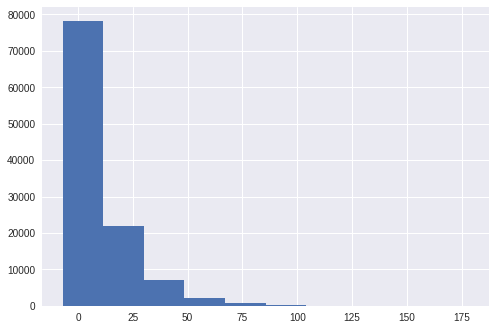

In [11]:
(df['AppointmentDay'] - df['ScheduledDay']).dt.days.hist();

In [12]:
(df['AppointmentDay'] - df['ScheduledDay']).dt.days.describe()

count    110527.000000
mean          9.183702
std          15.254996
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
dtype: float64

AppointmentDay generally appears to be later than ScheduledDay, so we will use it for the date of the actual appointment and correct the negative values.

In [13]:
df['Days_wait'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Days_wait
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1


In [14]:
df['Days_wait'][df['Days_wait'] < 0].value_counts()

-1    38563
-2        4
-7        1
Name: Days_wait, dtype: int64

Since almost all negative values in Days_wait are only one day I will assume there was an error with how the times were recorded and replace all negative values with 0.

In [15]:
#this line leaves the positive Days_wait values unchanged while replacing negative values with 0
df['Days_wait'] = df['Days_wait'].where(df['Days_wait'] > 0, other=0)


Now changing these columns to bool dataype: Scholarship, Hipertension, Diabetes, Alcoholism, SMS_received, No-show


In [16]:
cols_to_bool = ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received']

for col in cols_to_bool:
    df[col] = df[col].astype('bool')

In [17]:
def no_show_to_bool(row):
    if row['No-show'] == 'Yes':
        return True
    else:
        return False

In [18]:
df['No-show'] = df.apply(no_show_to_bool, axis=1)

In [19]:
df.dtypes

PatientId                float64
AppointmentID              int64
Gender                    object
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood             object
Scholarship                 bool
Hipertension                bool
Diabetes                    bool
Alcoholism                  bool
Handcap                    int64
SMS_received                bool
No-show                     bool
Days_wait                  int64
dtype: object

In [20]:
df['No-show'].value_counts()

False    88208
True     22319
Name: No-show, dtype: int64

Creating a column called 'Showed-up' that is the inverse of 'No-show' to make some of the analysis more intuitive.

In [21]:
df['Showed-up'] = df['No-show'].apply(lambda row: not row)
df[['No-show', 'Showed-up']].head()

,No-show,Showed-up
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


Examining the Age column for the negative values to see how to fix them.

In [22]:
df[df.Age < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Days_wait,Showed-up
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,False,False,False,False,0,False,False,0,True


Since only one row has a negative age value I'll just remove it

In [23]:
df = df.drop(99832)

Changing the Gender, Neighbourhood and Handcap columns to categories

In [24]:
cols_to_category = ['Gender', 'Neighbourhood', 'Handcap']
for col in cols_to_category:
    df[col] = df[col].astype('category')

df.dtypes

PatientId                float64
AppointmentID              int64
Gender                  category
ScheduledDay      datetime64[ns]
AppointmentDay    datetime64[ns]
Age                        int64
Neighbourhood           category
Scholarship                 bool
Hipertension                bool
Diabetes                    bool
Alcoholism                  bool
Handcap                 category
SMS_received                bool
No-show                     bool
Days_wait                  int64
Showed-up                   bool
dtype: object

<a id='eda'></a>
## Exploratory Data Analysis

### What factors might be important in determining if a patient will show up for their medical appointment?

First I'll explore the Age variable to get an idea of what the ages of the patients are.

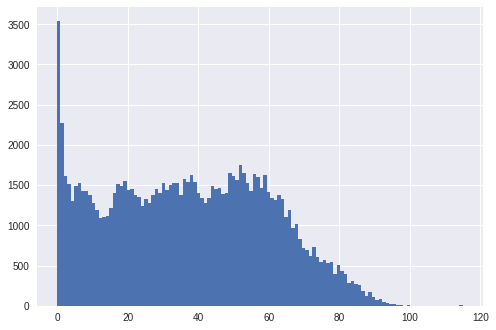

In [25]:
df.Age.hist(bins=116); #116 bins for full range of age values

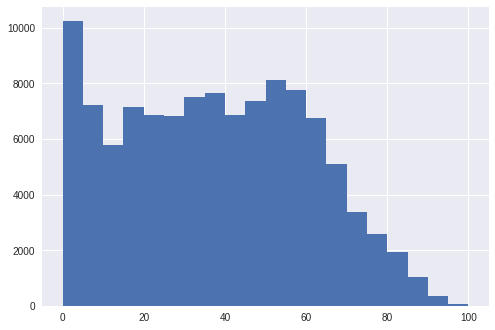

In [26]:
df.Age.hist(bins=20, range=(0,100));

The most common age group is babies, then relatively flat distribution until dropping off around age 65. We could look at age compared to the no-show rate to see if they could be related.

In [27]:
age_grouped_show = df[['Age', 'Showed-up']].groupby('Age')

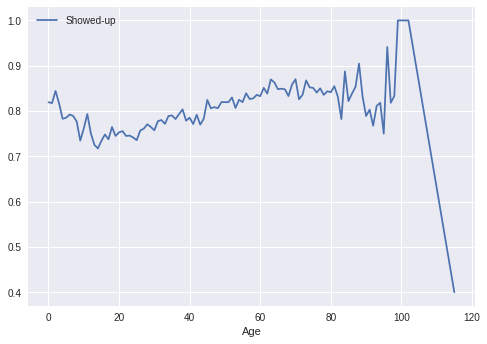

In [28]:
age_grouped_show.mean().plot();

It looks like almost all age groups of patients keep their appointments between 70% and 90% of the time, with a steadily increasing trend from young adulthood to around age 65 or 70, where the trend flattens out, then becomes more volatile, likely due to a lower number of patients that age.

Now lets look at the trend if broken down by gender to see if there's any difference in no-show rates

In [29]:
total_pop = df.shape[0]
males = df[df['Gender'] == 'M']
females = df[df['Gender'] == 'F']

gender_ratio = males.shape[0] / total_pop, females.shape[0] / total_pop

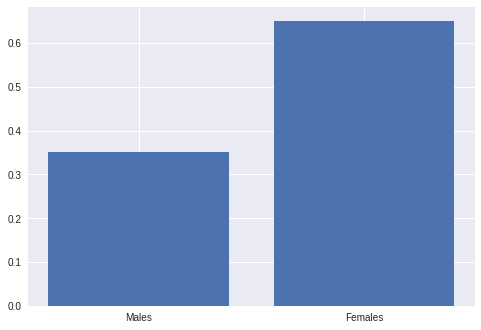

In [30]:
plt.bar((0,1), gender_ratio)
plt.xticks((0,1), ('Males', 'Females'))
plt.show()

In [31]:
gender_ratio

(0.3500262381702043, 0.6499737618297957)

The population of patients has about 35% males and 65% females.

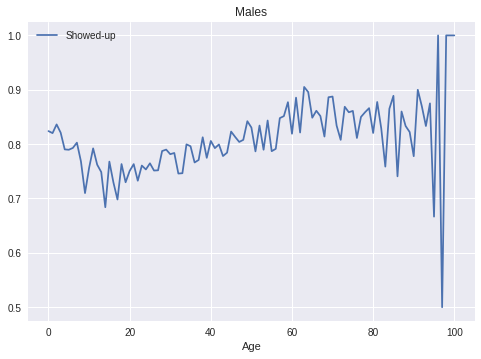

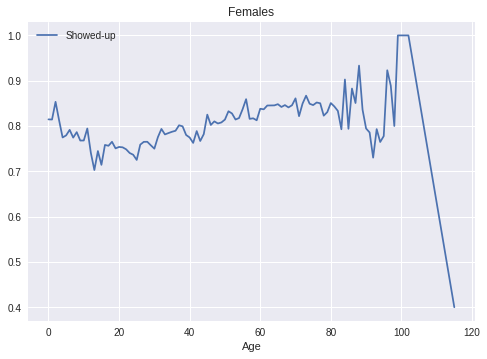

In [32]:
males[['Age', 'Showed-up']].groupby('Age').mean().plot(title='Males');
females[['Age', 'Showed-up']].groupby('Age').mean().plot(title='Females');

When seperated by gender the trends still appear similar to the total population and to each other, with more variance in the male chart, likely due to a much lower number of patients.

Now I'll look at the number of days a patient has to wait for an appointment, and if receiving an SMS reminder could have an effect on attendance.

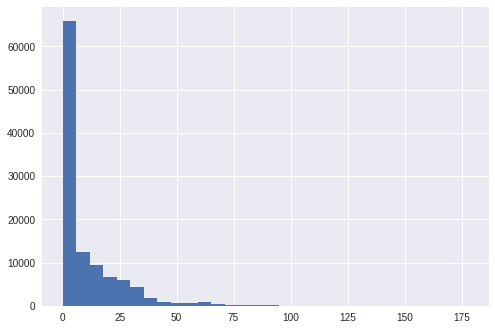

In [33]:
df['Days_wait'].hist(bins=30);

In [34]:
df['Days_wait'].describe()

count    110526.000000
mean          9.532825
std          15.027769
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: Days_wait, dtype: float64

Most patients have a wait time of less than two weeks, and half wait 3 days or less.

In [35]:
wait_grouped_show = df[['Days_wait', 'Showed-up']].groupby('Days_wait')

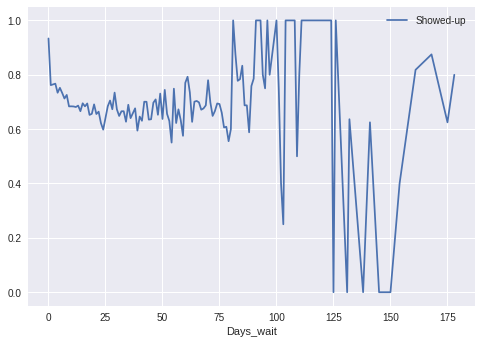

In [36]:
wait_grouped_show.mean().plot();

It looks like almost all patients keep their appointment if the wait time is under a day, but if it's longer than that only around 70% show up. Let's now see if getting an SMS reminder changes these results.

In [37]:
yes_sms = df[df['SMS_received'] == True]
no_sms = df[df['SMS_received'] == False]

In [38]:
yes_sms['Showed-up'].mean(), no_sms['Showed-up'].mean()

(0.72425455160363006, 0.8329646607323703)

That's unexpected that only around 72% of patients that recieved an SMS showed up for their appointment, but 83% of patients that didn't receive an SMS showed up. I wonder if it's because patients with a wait time of less than a day generally didn't receive an SMS reminder?

In [39]:
df[df['Days_wait'] == 0]['SMS_received'].mean()

0.0

Yes, none of the patients with a wait time less than a day received an SMS. Let's see if the attendance rate changes with an SMS reminder for patients that have to wait at least 1 day.

In [40]:
sms_wait = yes_sms[yes_sms['Days_wait'] > 0]
no_sms_wait = no_sms[no_sms['Days_wait'] > 0]

sms_wait['Showed-up'].mean(), no_sms_wait['Showed-up'].mean()

(0.72425455160363006, 0.69213792221084958)

When a patient has to wait at least a day receiving an SMS seems to slightly increase the chance of showing up.

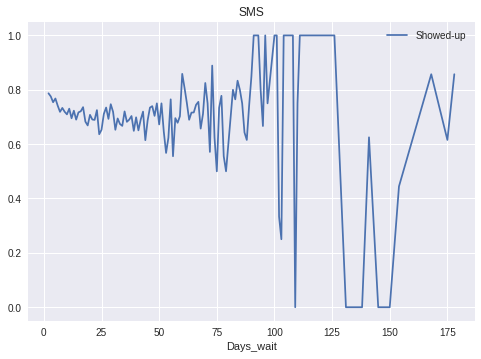

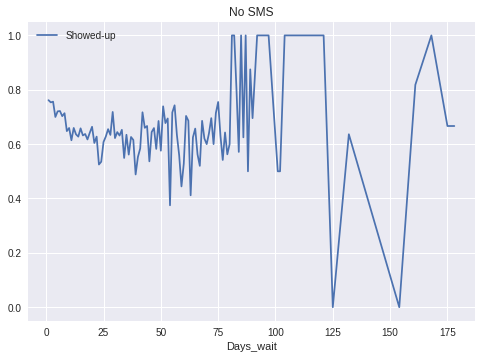

In [41]:
sms_wait[['Days_wait', 'Showed-up']].groupby('Days_wait').mean().plot(title='SMS');
no_sms_wait[['Days_wait', 'Showed-up']].groupby('Days_wait').mean().plot(title='No SMS');

When patients receive an SMS reminder it appears that their attendance rates are generally a little bit higher, for the most common wait times. This would need to be investigated further to see if it's a significant way to help patients keep their appointments.

<a id='conclusions'></a>
## Conclusions

In this report I looked into the details of the patients and their scheduling information in the dataset, and found some results that might be useful in recommending changes to help more patients keep their appointments. From looking at the patients' ages, the younger patients had a lower attendance rate, so it might make sense to focus on trying to help them improve. By looking at the patients seperated by gender the attendance rates were similar, but overall there were twice as many women than men, which could suggest that men are much less likely to even setup a medical appointment, but this would need to be investigated more to see if this data is a representative sample of the whole population, or if it's biased in some way. When examining the wait time for an appointment, most patients had a short wait time of under 2 weeks, but the best attendance rate was when the appointment was the same day it was scheduled. It appears that if a patient is not able to book a same day appointment, then sending them an SMS reminder might increase attendance, but this would need to be proved with more rigorous statistical testing.

<a id='sources'></a>
## Sources

https://www.kaggle.com/joniarroba/noshowappointments/discussion